In [120]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
import librosa
import numpy as np
import matplotlib.pyplot as plt
from minisom import MiniSom
import pickle
import librosa
from sklearn.preprocessing import MinMaxScaler
import os
from bitstring import ConstBitStream
import librosa
import numpy as np
from sklearn.decomposition import KernelPCA
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import FeatureAgglomeration
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
import pickle
from tensorflow.keras import layers, models



In [121]:
# Preprocessing functions
sample_rate=96000

def read_i32(filepath):
    with open(filepath, 'rb') as file:
        data = file.read()
        sample_rate = 96000
        float_array = np.frombuffer(data, dtype=np.float32)
    return np.array(float_array), sample_rate

def feature_extraction(signal, sr, n_fft=2048, hop_length=512, n_mels=64, frames=15, pore_frequency_range=(500, 2000), max_feature_length=3069):
    # Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(
        y=signal,
        sr=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Pore amplitude feature
    pore_amplitude = np.mean(np.abs(librosa.core.stft(signal, n_fft=n_fft, hop_length=hop_length)[pore_frequency_range[0]//10:pore_frequency_range[1]//10, :]), axis=0)

    # Spectral contrast feature
    spectral_contrast = librosa.feature.spectral_contrast(y=signal, sr=sample_rate, hop_length=hop_length)

    # Statistical descriptors for spectral contrast
    mean_spectral_contrast = np.mean(spectral_contrast, axis=0)
    std_spectral_contrast = np.std(spectral_contrast, axis=0)

    # Combine existing and additional features
    features_vector_size = log_mel_spectrogram.shape[1] - frames + 1
    dims = frames * n_mels + 3  # 1 for pore amplitude, 2 for mean and std of spectral contrast

    if features_vector_size < 1:
        return np.empty((0, dims), np.float32)

    features = np.zeros((features_vector_size, dims), np.float32)

    for t in range(frames):
        features[:, n_mels * t: n_mels * (t + 1)] = log_mel_spectrogram[:, t:t + features_vector_size].T

    # Insert the pore amplitude feature
    features[:, -3] = pore_amplitude[:features_vector_size]

    # Insert mean and std of spectral contrast
    features[:, -2] = mean_spectral_contrast[:features_vector_size]
    features[:, -1] = std_spectral_contrast[:features_vector_size]

    # Zero-pad or truncate the feature vectors to a consistent length
    if features.shape[0] < max_feature_length:
        padded_features = np.zeros((max_feature_length, dims), dtype=features.dtype)
        padded_features[:features_vector_size, :] = features
        features = padded_features
    elif features.shape[0] > max_feature_length:
        features = features[:max_feature_length, :]

    return features

# Function to process files and extract features
def process_files(directory):
    feature_dataset = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            if "MikroGefell1_96khz" in file:
                file_path = os.path.join(root, file)
                data_array, sample_rate = read_i32(file_path)
                # Extract features using the provided function
                features= feature_extraction(data_array, sample_rate)
                feature_dataset.append(features)

    # Convert the list of arrays into a 2D array
    feature_dataset = np.vstack(feature_dataset)
    return feature_dataset


In [188]:
# Directory to load data from
normal_directory_path = "./Project_Files/Dataset/npore/"
abnormal_directory_path = "./Project_Files/Dataset/pore/"

# Process files to get feature dataset
train_data= process_files(normal_directory_path)
test_data= process_files(abnormal_directory_path)


In [151]:
# Define the file path to save data as a pickle
train_pickle = "./Project_Files/Dataset/train_no_pore_96khz.pkl"
test_pickle = "./Project_Files/Dataset/test_pore_96khz.pkl"

# Save the train_data as a pickle file
with open(train_pickle, 'wb') as file:
    pickle.dump(train_data, file)
with open(test_pickle, 'wb') as file: 
    pickle.dump(test_data, file)


## Display the features

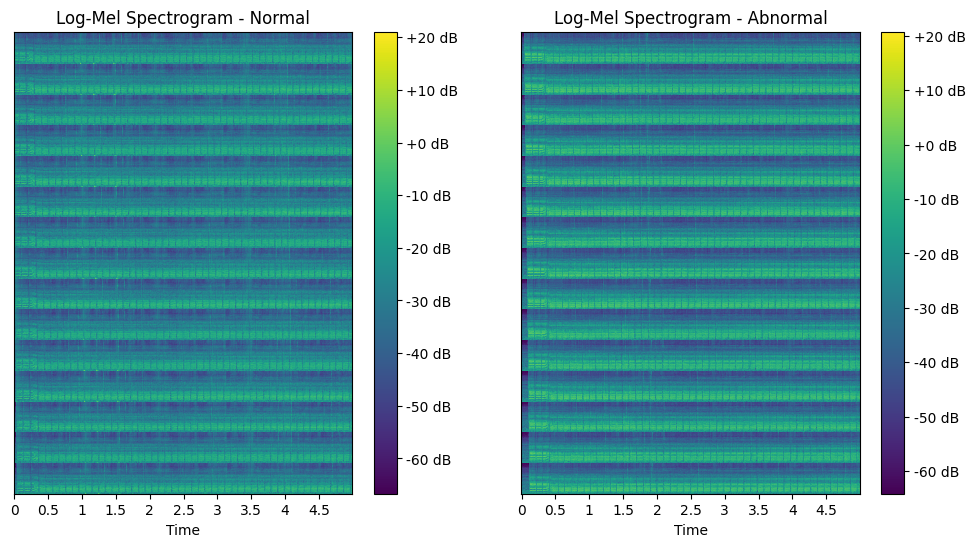

(153450, 963)
(150381, 963)


In [152]:
plt.figure(figsize=(12, 6))
sample_rate=96000
# Plot the first subplot with the initial part of train_data
plt.subplot(1, 2, 1)
librosa.display.specshow(train_data.T[:, :int(5 * sample_rate / 512)], x_axis='time', sr=sample_rate, hop_length=512, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram - Normal')

# Plot the second subplot with the initial part of test_data
plt.subplot(1, 2, 2)
librosa.display.specshow(test_data.T[:, :int(5 * sample_rate / 512)], x_axis='time', sr=sample_rate, hop_length=512, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram - Abnormal')
plt.show()
print(train_data.shape)
print(test_data.shape)

The first dimension (153450) refers to the number of samples or instances in your dataset. Each row in the matrix corresponds to a separate sample.

The second dimension (963) represents the number of features for each sample. Each column in the matrix corresponds to a feature.



## Scaling and Feature Agglomeration
### Variance Thresholding:

Purpose: The main goal of variance thresholding is to remove features with low variance. Features with low variance indicate that they don't vary much across the dataset and might not contain much information.
Operation: For each feature, the variance is calculated, and features with variance below a certain threshold are removed. This can be useful to eliminate constant or near-constant features that don't contribute much to the model.
### Feature Agglomeration:

Purpose: Feature agglomeration is a technique used for clustering similar features together into groups. The idea is to reduce the dimensionality of the dataset by representing each group of features with a single aggregated feature.
Operation: Features are grouped into clusters, and for each cluster, a representative feature (e.g., the mean or median of the features in the cluster) is computed. The dataset is then transformed to contain these representative features. The number of clusters determines the reduced dimensionality.'

## Why not PCA?
Feature Agglomeration and Principal Component Analysis (PCA) are both dimensionality reduction techniques, but they differ in their approaches and the information they retain.

1. **Feature Agglomeration:**
   - **Approach:** Feature agglomeration is a clustering-based method. It groups similar features together into clusters and represents each cluster with a single aggregated feature.
   - **Information Retention:** Feature agglomeration retains the original features in terms of their cluster representatives. The transformed dataset has fewer features, with each feature representing a cluster.

2. **Principal Component Analysis (PCA):**
   - **Approach:** PCA is a linear transformation technique that finds orthogonal axes (principal components) along which the data has maximum variance.
   - **Information Retention:** PCA retains information by capturing the directions of maximum variance in the data. Principal components are linear combinations of the original features, and they are ordered by the amount of variance they explain.

**Differences:**
   - **Linearity:** PCA is a linear technique, meaning it finds linear combinations of features. Feature agglomeration, on the other hand, is more flexible and can capture non-linear relationships by grouping similar features together.
   - **Representation:** Feature agglomeration retains the original features, though they are clustered. PCA provides a new set of uncorrelated variables (principal components) that may not correspond directly to the original features.
   - **Dimensionality Reduction:** PCA typically reduces dimensionality by creating a smaller set of principal components that explain most of the variance. Feature agglomeration reduces dimensionality by grouping features into clusters.


In [164]:
# Read the saved data to scale and aggloremate features
train_pickle = "./Project_Files/Dataset/train_no_pore_96khz.pkl"
test_pickle = "./Project_Files/Dataset/test_pore_96khz.pkl"

with open(train_pickle, 'rb') as file:
    train_data = pickle.load(file)

with open(test_pickle, 'rb') as file:
    test_data = pickle.load(file)

In [182]:
# Define feature agglomeration and scaling function 
def preprocess_data(train_data, test_data, n_clusters):
    # Adjust the number of clusters based on your requirements
    selector = FeatureAgglomeration(n_clusters=n_clusters)
    scaler = StandardScaler()

    # Standardize the data after feature agglomeration
    X_train_scaled = scaler.fit_transform(train_data)
    X_test_scaled = scaler.transform(test_data)

    # Transform the test data using the same selector

    # Fit and transform the training data with feature agglomeration
    X_train_selected = selector.fit_transform(X_train_scaled)
    # Transform the test data using the same selector
    X_test_selected = selector.transform(X_test_scaled)
    scaler_file_path = "scaler.pkl"

    # Save the scaler object to a file
    with open(scaler_file_path, 'wb') as file:
        pickle.dump(scaler, file)
    selector_file_path = "selector.pkl"

    with open(selector_file_path, 'wb') as file:
        pickle.dump(selector, file)

    return X_train_selected, X_test_selected
    # Define the file path to save the scaler object


In [249]:
# Define the number of clusters for feature agglomeration after scaling 
n_clusters = 12
X_train_selected, X_test_selected = preprocess_data(train_data, test_data, n_clusters)
print(X_train_selected.shape)


(153450, 12)


## Displaying the preprocessed data

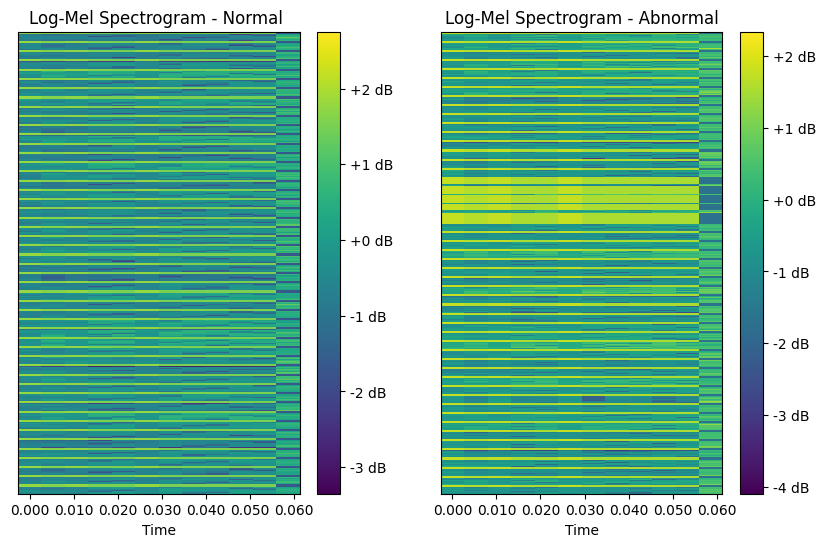

In [237]:
plt.figure(figsize=(10, 6))
sr=96000
plt.subplot(1, 2, 1)
librosa.display.specshow(X_train_selected[:, :int(5 * sr / 512)], x_axis='time', sr=sr, hop_length=512, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram - Normal ')

# Plot the second subplot with the initial part of test_data
plt.subplot(1, 2, 2)
librosa.display.specshow(X_test_selected[:, :int(5 * sr / 512)], x_axis='time', sr=sr, hop_length=512, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram - Abnormal')

plt.show()


In [251]:
#  Define the file path to save processed data
train_pickle = "./Project_Files/Dataset/train_no_pore_96khz_processed.pkl"
test_pickle = "./Project_Files/Dataset/test_pore_96khz_processed.pkl"

# Save the train_data as a pickle file
with open(train_pickle, 'wb') as file:
    pickle.dump(X_train_selected, file)
with open(test_pickle, 'wb') as file:
    pickle.dump(X_test_selected, file)


## Training

In [253]:
# Train the autoencoder with data generator
def learning_rate_scheduler(epoch, lr):

    if epoch < 15:
        return lr  # Keep the initial learning rate for the first 10 epochs
    else:
      return lr * tf.math.exp(-0.1)  # Decay the learning rate exponentially

def data_generator(features, batch_size):
    while True:
        indices = np.random.choice(features.shape[0], size=batch_size, replace=False)
        yield features[indices, :], features[indices, :]

batch_size = 8

model = models.Sequential([
    tf.keras.layers.Input(shape=(X_train_selected.shape[1],)),    
    # tf.keras.layers.BatchNormalization(),  
    tf.keras.layers.Dense(16, activation='relu'),
    # tf.keras.layers.BatchNormalization(),  
    tf.keras.layers.Dense(8, activation='relu'),
    # tf.keras.layers.BatchNormalization(),  
    tf.keras.layers.Dense(16, activation='relu'),
    # tf.keras.layers.BatchNormalization(),  
    tf.keras.layers.Dense(X_train_selected.shape[1], activation='sigmoid')
])
X_train_data, X_val_data = train_test_split(X_train_selected, test_size=0.2, random_state=42)

train_generator = data_generator(X_train_data, batch_size)
val_generator = data_generator(X_val_data, batch_size)

lr_scheduler = LearningRateScheduler(learning_rate_scheduler)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['accuracy'])
history = model.fit(train_generator, epochs=30, steps_per_epoch=len(X_train_data)//batch_size, validation_data=val_generator, validation_steps=len(X_val_data)//batch_size,callbacks=[lr_scheduler])
model.save('pore_classifier.h5')

In [254]:
# Model Summary
model = tf.keras.models.load_model('pore_classifier.h5')
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 16)                208       
                                                                 
 dense_41 (Dense)            (None, 8)                 136       
                                                                 
 dense_42 (Dense)            (None, 16)                144       
                                                                 
 dense_43 (Dense)            (None, 12)                204       
                                                                 
Total params: 692 (2.70 KB)
Trainable params: 692 (2.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming reconstruction_errors_test is the array of reconstruction errors
# and predictions_test is the binary array indicating abnormal (1) or normal (0) based on a threshold

# Define a threshold (you may want to fine-tune this based on your specific case)
threshold = 0.43866489608647974

# Classify samples as normal or abnormal based on the threshold
predictions = reconstruction_errors_test > threshold

# Example: If you have some threshold, you can classify as normal/abnormal
# predictions = (reconstruction_errors_test > threshold).astype(int)

# Calculate Precision, Recall, and F1-score
precision = precision_score(predictions_test, predictions)
recall = recall_score(predictions_test, predictions)
f1 = f1_score(predictions_test, predictions)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
test_loss, test_acc = model.evaluate(X_test_selected, y_test)
print(f'Test accuracy: {test_acc}')

## Testing on Original Samples
#### Train_Data : Wall_17_AL_io_20220614
#### Test_Data : Wall_23_AL_Oel_Zusatz_20220620

In [174]:
# Load Train and Test processed file
train_pickle = "./Project_Files/Dataset/train_no_pore_96khz_processed.pkl"
test_pickle = "./Project_Files/Dataset/test_pore_96khz_processed.pkl"

with open(train_pickle, 'rb') as file:
    train_data_process = pickle.load(file)
with open(test_pickle, 'rb') as file:
    test_data_process = pickle.load(file)

X_train_selected=train_data_process
X_test_selected=test_data_process
threshold=0.43866489608647974

4892/4892 [==============================] - 2s 460us/step
Number of instances where Non-Pore is high: 31705
Number of instances where Pores is high: 124814
Pore


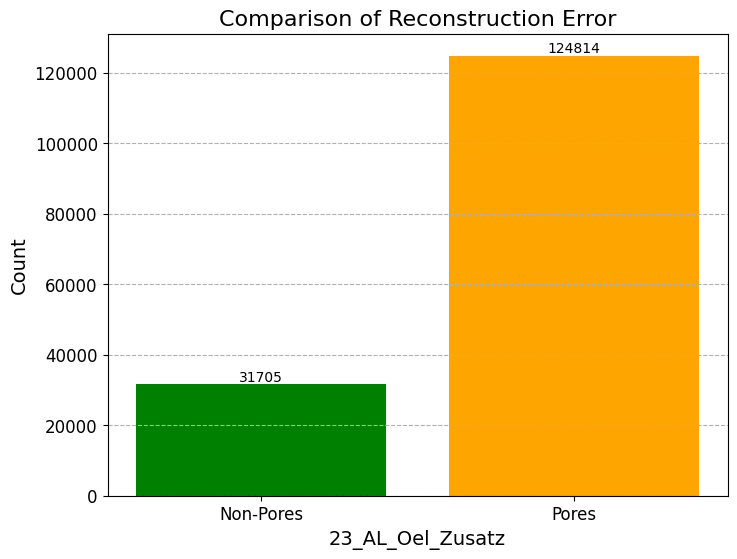

In [257]:
# Load the trained autoencoder model
model = tf.keras.models.load_model('pore_classifier.h5')

# Use the autoencoder to reconstruct the data
reconstructed_data = model.predict(X_train_selected)

# Calculate reconstruction errors
reconstruction_errors_train = np.mean(np.square(X_train_selected - reconstructed_data), axis=1)

reconstructed_data = model.predict(X_test_selected)

# Calculate reconstruction errors
reconstruction_errors_test = np.mean(np.square(X_test_selected - reconstructed_data), axis=1)

# Plot the reconstruction errors for train and test data

# Reshape arrays to have a common size for broadcasting
common_size = max(reconstruction_errors_train.size, reconstruction_errors_test.size)
reshaped_train = np.resize(reconstruction_errors_train, common_size)
reshaped_test = np.resize(reconstruction_errors_test, common_size)

# Element-wise comparison
comparison_result = np.greater(reshaped_train, reshaped_test)
# print(comparison_result)
# Count the number of True values (where list1 has higher values)
higher_values_count = np.sum(comparison_result)

# Count the number of False values (where list2 has higher values)
lower_values_count = len(comparison_result) - higher_values_count

# Print the results
print(f"Number of instances where Non-Pore is high: {higher_values_count}")
print(f"Number of instances where Pores is high: {lower_values_count}")

predictions_test = (higher_values_count) < lower_values_count

if predictions_test:
    classification = "Pore"
else:
    classification = "Non-Pore"

print(classification)

# Plot the comparison result
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(['Non-Pores', 'Pores'], [higher_values_count, lower_values_count], color=['green', 'orange'])

# Add data labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom', fontsize=10, color='black')

# Title and labels
plt.title('Comparison of Reconstruction Error', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xlabel('23_AL_Oel_Zusatz', fontsize=14)
# Style adjustments
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.show()

In [260]:
# Testing threshold
from sklearn.metrics import precision_score, recall_score, f1_score

rec_train=np.mean(reconstruction_errors_train)
rec_test=np.mean(reconstruction_errors_test)

# Calculate the threshold (you may want to fine-tune this value)
threshold = (np.max(np.mean(rec_train)) + np.min(np.mean(rec_train))) * 0.5
print(threshold)
# Classify samples as normal or abnormal
predictions_normal = (rec_train) > threshold
predictions_test = (rec_test) > threshold

if predictions_normal or predictions_test:
    classification = "Pore"
else:
    classification = "Non-Pore"

# print(classification)

# Assuming reconstruction_errors_test is the array of reconstruction errors
# and predictions_test is the binary array indicating abnormal (1) or normal (0) based on a threshold

# Define a threshold (you may want to fine-tune this based on your specific case)

# Classify samples as normal or abnormal based on the threshold
predictions = reconstruction_errors_test > threshold

# Example: If you have some threshold, you can classify as normal/abnormal
# predictions = (reconstruction_errors_test > threshold).astype(int)

# Calculate Precision, Recall, and F1-score
# precision = precision_score(predictions_test, predictions)
recall = recall_score(predictions_test, predictions)
f1 = f1_score(predictions_test, predictions)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


0.43866489608647974


InvalidParameterError: The 'y_true' parameter of recall_score must be an array-like or a sparse matrix. Got True instead.

## Testing on 3 kinds of Samples: 
###  AL_Oel, GF50, and GF90

In [232]:
# Loading scaler and selector objects from pickle files

scaler_file_path = "scaler.pkl"
# Save the scaler object to a file

with open(scaler_file_path, 'rb') as file:
    scaler = pickle.load(file)
selector_file_path = "selector.pkl"
with open(selector_file_path, 'rb') as file:
    selector = pickle.load(file)

### Test1: Wall_12_AL_Oel_20220615

96/96 [==============================] - 0s 396us/step
Number of instances where Non-Pore is high: 332
Number of instances where Pores is high: 2737
Pore


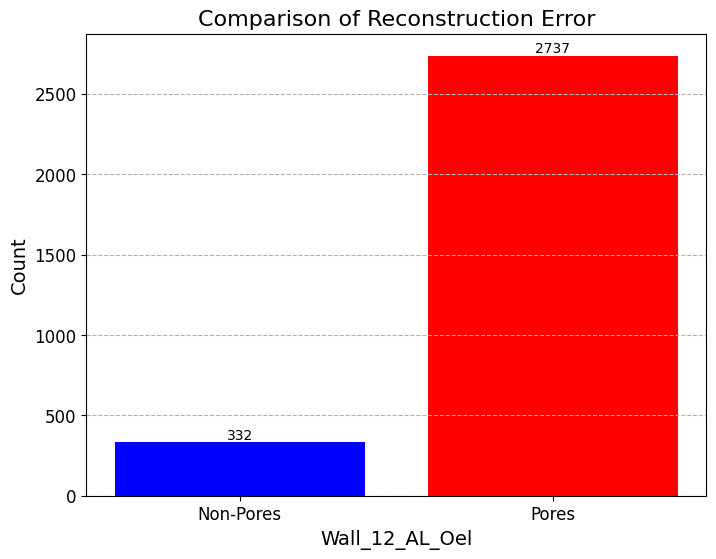

In [244]:
# Loading AL_Oel_20220615 Data
test_directory = "./Project_Files/test/Wall_12_AL_Oel_20220615/"
normal_dir = "./Project_Files/normal/Wall_17_AL_io_20220614/"

# Single sample # L24_10-34-35_no-oel_nio-oel-fail-AL_OEL 
test_directory = "./Project_Files/Test_data/L33_09-26-19_nio-gas50-pass-GF50/"
normal_dir = "./Project_Files/normal/L08_09-59-44_io-pass/"

testing_file= process_files(test_directory)
normal_file= process_files(normal_dir)

model = tf.keras.models.load_model('pore_classifier.h5')

# Standardize the data after feature agglomeration
X_test_scaled_ = scaler.transform(testing_file)

# Transform the test data using the same selector
X_test_selected_ = selector.transform(X_test_scaled_)
#X_test_selected_ = X_test_selected_.reshape(-1,1)
reconstructed_data = model.predict(X_test_selected_)

# Calculate reconstruction errors
reconstruction_errors_test = np.mean(np.square(X_test_selected_ - reconstructed_data), axis=1)

# Standardize the data after feature agglomeration
x_normal = scaler.transform(normal_file)

# Transform the test data using the same selector
X_normal = selector.transform(x_normal)
# Use the autoencoder to reconstruct the data
reconstructed_data = model.predict(X_normal)

# Calculate reconstruction errors
reconstruction_errors_train = np.mean(np.square(X_normal - reconstructed_data), axis=1)

# Reshape arrays to have a common size for broadcasting
common_size = max(reconstruction_errors_train.size, reconstruction_errors_test.size)
reshaped_train = np.resize(reconstruction_errors_train, common_size)
reshaped_test = np.resize(reconstruction_errors_test, common_size)

# Element-wise comparison
comparison_result = np.greater(reshaped_train, reshaped_test)
# print(comparison_result)
# Count the number of True values (where list1 has higher values)
higher_values_count = np.sum(comparison_result)

# Count the number of False values (where list2 has higher values)
lower_values_count = len(comparison_result) - higher_values_count

# Print the results
print(f"Number of instances where Non-Pore is high: {higher_values_count}")
print(f"Number of instances where Pores is high: {lower_values_count}")

predictions_test = (higher_values_count) < lower_values_count

if predictions_test:
    classification = "Pore"
else:
    classification = "Non-Pore"

print(classification)

# Plot the comparison result
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(['Non-Pores', 'Pores'], [higher_values_count, lower_values_count], color=['blue', 'red'])

# Add data labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom', fontsize=10, color='black')

# Title and labels
plt.title('Comparison of Reconstruction Error', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Wall_12_AL_Oel', fontsize=14)

# Style adjustments
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.show()

### Test2: Wall_22_AL_GF50_20220615

96/96 [==============================] - 0s 412us/step
Number of instances where Non-Pore is high: 52
Number of instances where Pores is high: 3017
Pore


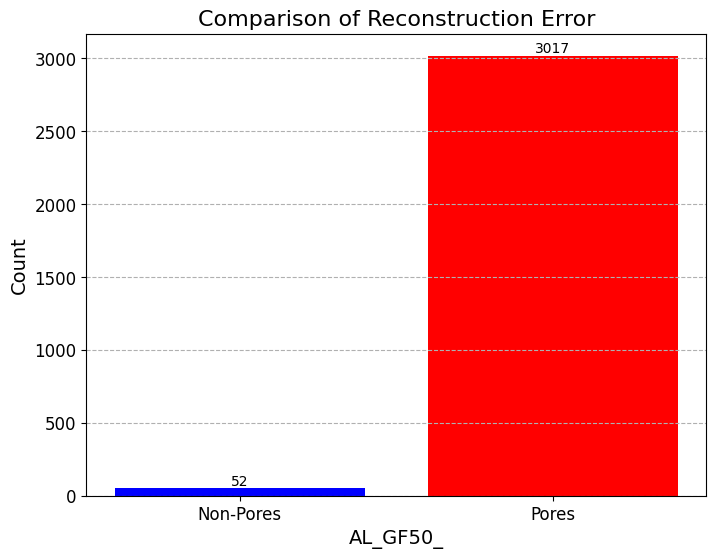

In [245]:
# Loading AL_GF50 Data
test_directory = "./Project_Files/test/Wall_22_AL_GF50_20220615/"
normal_dir = "./Project_Files/normal/Wall_17_AL_io_20220614/"

# L24_09-20-21_nio-gas50-pass-GF50 - single sample
test_directory = "./Project_Files/Test_data/L24_09-20-21_nio-gas50-pass-GF50/"
normal_dir = "./Project_Files/normal/L08_09-59-44_io-pass/"

testing_file= process_files(test_directory)
normal_file= process_files(normal_dir)

model = tf.keras.models.load_model('pore_classifier.h5')

# Standardize the data after feature agglomeration
X_test_scaled_ = scaler.transform(testing_file)

# Transform the test data using the same selector
X_test_selected_ = selector.transform(X_test_scaled_)
#X_test_selected_ = X_test_selected_.reshape(-1,1)
reconstructed_data = model.predict(X_test_selected_)

# Calculate reconstruction errors
reconstruction_errors_test = np.mean(np.square(X_test_selected_ - reconstructed_data), axis=1)

# Standardize the data after feature agglomeration
x_normal = scaler.transform(normal_file)

# Transform the test data using the same selector
X_normal = selector.transform(x_normal)
# Use the autoencoder to reconstruct the data
reconstructed_data = model.predict(X_normal)

# Calculate reconstruction errors
reconstruction_errors_train = np.mean(np.square(X_normal - reconstructed_data), axis=1)

# Reshape arrays to have a common size for broadcasting
common_size = max(reconstruction_errors_train.size, reconstruction_errors_test.size)
reshaped_train = np.resize(reconstruction_errors_train, common_size)
reshaped_test = np.resize(reconstruction_errors_test, common_size)

# Element-wise comparison
comparison_result = np.greater(reshaped_train, reshaped_test)
# print(comparison_result)
# Count the number of True values (where list1 has higher values)
higher_values_count = np.sum(comparison_result)

# Count the number of False values (where list2 has higher values)
lower_values_count = len(comparison_result) - higher_values_count

# Print the results
print(f"Number of instances where Non-Pore is high: {higher_values_count}")
print(f"Number of instances where Pores is high: {lower_values_count}")

predictions_test = (higher_values_count) < lower_values_count

if predictions_test:
    classification = "Pore"
else:
    classification = "Non-Pore"

print(classification)

# Plot the comparison result
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(['Non-Pores', 'Pores'], [higher_values_count, lower_values_count], color=['blue', 'red'])

# Add data labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom', fontsize=10, color='black')

# Title and labels
plt.title('Comparison of Reconstruction Error', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xlabel('AL_GF50_', fontsize=14)

# Style adjustments
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.show()

### Test3: Wall_13_AL_GF90_20220614

4796/4796 [==============================] - 2s 418us/step
Number of instances where Non-Pore is high: 49944
Number of instances where Pores is high: 103506
Pore


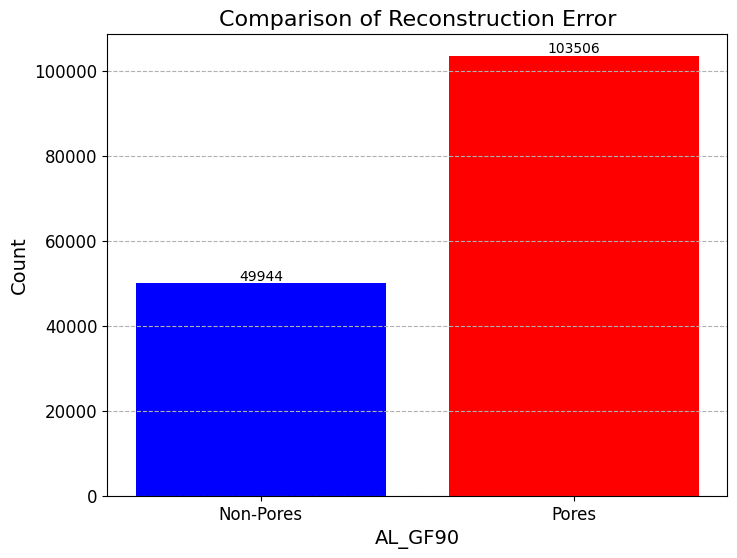

In [246]:
# Loading AL_GF90 Data

# L24_09-20-21_nio-gas50-pass-GF50 - SAMPLE NAME
test_directory = "./Project_Files/test/Wall_13_AL_GF90_20220614/"
normal_dir = "./Project_Files/normal/L08_09-59-44_io-pass/"

testing_file= process_files(test_directory)
normal_file= process_files(normal_dir)

model = tf.keras.models.load_model('pore_classifier.h5')

# Standardize the data after feature agglomeration
X_test_scaled_ = scaler.transform(testing_file)

# Transform the test data using the same selector
X_test_selected_ = selector.transform(X_test_scaled_)
#X_test_selected_ = X_test_selected_.reshape(-1,1)
reconstructed_data = model.predict(X_test_selected_)

# Calculate reconstruction errors
reconstruction_errors_test = np.mean(np.square(X_test_selected_ - reconstructed_data), axis=1)

# Standardize the data after feature agglomeration
x_normal = scaler.transform(normal_file)

# Transform the test data using the same selector
X_normal = selector.transform(x_normal)
# Use the autoencoder to reconstruct the data
reconstructed_data = model.predict(X_train_selected)

# Calculate reconstruction errors
reconstruction_errors_train = np.mean(np.square(X_train_selected - reconstructed_data), axis=1)

# Reshape arrays to have a common size for broadcasting
common_size = max(reconstruction_errors_train.size, reconstruction_errors_test.size)
reshaped_train = np.resize(reconstruction_errors_train, common_size)
reshaped_test = np.resize(reconstruction_errors_test, common_size)

# Element-wise comparison
comparison_result = np.greater(reshaped_train, reshaped_test)
# print(comparison_result)
# Count the number of True values (where list1 has higher values)
higher_values_count = np.sum(comparison_result)

# Count the number of False values (where list2 has higher values)
lower_values_count = len(comparison_result) - higher_values_count

# Print the results
print(f"Number of instances where Non-Pore is high: {higher_values_count}")
print(f"Number of instances where Pores is high: {lower_values_count}")

predictions_test = (higher_values_count) < lower_values_count

if predictions_test:
    classification = "Pore"
else:
    classification = "Non-Pore"

print(classification)

# Plot the comparison result
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(['Non-Pores', 'Pores'], [higher_values_count, lower_values_count], color=['blue', 'red'])

# Add data labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, round(yval, 2), ha='center', va='bottom', fontsize=10, color='black')

# Title and labels
plt.title('Comparison of Reconstruction Error', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xlabel('AL_GF90', fontsize=14)

# Style adjustments
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.show()